<a href="https://colab.research.google.com/github/anologicon/tickets-forecasting-tcc/blob/master/ticket_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de conclusão de curso

APLICAÇÃO DE  APRENDIZAGEM SUPERVISIONADA PARA PREVISÕES DE VENDAS DE INGRESSOS DE SESSÕES DE CINEMA


In [81]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import holidays
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [82]:
# Devido o Plotly estar sendo utilizado no Google Collab, precisaremos definir
# a função abaixo e chamá-la sempre que quisermos exibir um gráfico

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

### Caminho para a base de dados

In [83]:
pathFile = "/content/drive/My Drive/Colab Notebooks/TicketsForecasting/TCC1/train_anonimo.csv"

pathValidate = "/content/drive/My Drive/Colab Notebooks/TicketsForecasting/TCC1/validation_anonimo.csv"

### Importando dados

In [84]:
train = pd.read_csv(pathFile, parse_dates=['dataHoraSessao'], index_col=[0]);

validation = pd.read_csv(pathValidate, parse_dates=['dataHoraSessao'], index_col=[0]);

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



### Ordenando os dados de forma ascendente

In [85]:
train.sort_values("dataHoraSessao", axis=0, ascending = True, inplace = True)
validation.sort_values("dataHoraSessao", axis=0, ascending = True, inplace = True)

In [86]:
train.columns

Index(['dataHoraSessao', 'nomeFilme', 'distribuidor', 'salaCinema', 'diretor',
       'classificacao', 'tempoFilme', 'releaseYear', 'slug', 'tmdbId',
       'original_title', 'release_date', 'cast_0', 'cast_1', 'cast_2',
       'key_word_0', 'key_word_1', 'key_word_2', 'revenue', 'budget',
       'popularity', 'vote_average', 'vote_count', 'Animação', 'Aventura',
       'Ação', 'Comédia', 'Crime', 'Drama', 'Família', 'Fantasia', 'Suspense',
       'Terror', 'Thriller', 'Biografia', 'Documentário', 'Esporte',
       'Faroeste', 'Ficção ', 'Ficção científica', 'Histórico', 'Mistério',
       'Musical', 'Romance', 'qtdIngressos'],
      dtype='object')

In [87]:
br_holidays = holidays.Brazil()

def newFeatures(dataset):

    # Separando o mes da sessão
    dataset['mes'] = dataset.dataHoraSessao.dt.month

    # Data sem hora
    dataset['data'] = dataset.dataHoraSessao.dt.date
   
    # Separando o dia da sessão
    dataset['dia'] = dataset.dataHoraSessao.dt.day

    # Separando a hora da sessão
    dataset['hora'] = dataset.dataHoraSessao.dt.hour
    
    # Dia do ano
    dataset['diaAno'] = dataset.dataHoraSessao.dt.dayofyear

    # Semana do ano
    dataset['semanaAno'] = dataset.dataHoraSessao.dt.weekofyear

    # Separando o dia da semana
    dataset['diaSemana'] = dataset.dataHoraSessao.dt.dayofweek
    
    # Separando se é feriado ou não
    dataset['isFeriado'] = dataset.dataHoraSessao.apply(lambda x: x in br_holidays)
    
    # Separando se é fim de semana ou não
    dataset['fimDeSemana'] = dataset.dataHoraSessao.apply(lambda x:1 if(x.dayofweek == 5 or x.dayofweek == 6) else 0)

    return dataset

In [88]:
train_featured = newFeatures(train);
validation_featured = newFeatures(validation);

## Verificando valores das colunas

In [89]:
linha,coluna = train.shape

print("O dataset contem: \n")
print(str(linha)+" linhas \n")
print(str(coluna)+" colunas")

O dataset contem: 

25758 linhas 

54 colunas


### Visualizando as 5 primeiras linhas

In [90]:
train.head()

,dataHoraSessao,nomeFilme,distribuidor,salaCinema,diretor,classificacao,tempoFilme,releaseYear,slug,tmdbId,original_title,release_date,cast_0,cast_1,cast_2,key_word_0,key_word_1,key_word_2,revenue,budget,popularity,vote_average,vote_count,Animação,Aventura,Ação,Comédia,Crime,Drama,Família,Fantasia,Suspense,Terror,Thriller,Biografia,Documentário,Esporte,Faroeste,Ficção,Ficção científica,Histórico,Mistério,Musical,Romance,qtdIngressos,mes,data,dia,hora,diaAno,semanaAno,diaSemana,isFeriado,fimDeSemana
0,2017-06-17 15:00:00,Sol da meia-noite,Diamond Filmes,Sala 02,Scott Speer,12,92,2018,sol-da-meia-noite,419478.0,Midnight Sun,2018-03-22 00:00:00,Bella Thorne,Patrick Schwarzenegger,Rob Riggle,seattle,sunlight,terminal illness,2.736547e+07,0.0,14.549,7.7,2095.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,6,2017-06-17,17,15,168,24,5,False,1
1,2017-06-17 15:30:00,Jurassic World: Reino Ameaçado,Universal,Sala 01,J.A. Bayona,12,130,2018,jurassic-world-reino-ameacado,351286.0,Jurassic World: Fallen Kingdom,2018-06-06 00:00:00,Chris Pratt,Bryce Dallas Howard,Rafe Spall,tyrannosaurus rex,volcano,sequel,1.303460e+09,170000000.0,44.888,6.5,7502.0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6,2017-06-17,17,15,168,24,5,False,1
2,2017-06-17 15:30:00,Jurassic World: Reino Ameaçado,Universal,Sala 03,J.A. Bayona,12,130,2018,jurassic-world-reino-ameacado,351286.0,Jurassic World: Fallen Kingdom,2018-06-06 00:00:00,Chris Pratt,Bryce Dallas Howard,Rafe Spall,tyrannosaurus rex,volcano,sequel,1.303460e+09,170000000.0,44.888,6.5,7502.0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,6,2017-06-17,17,15,168,24,5,False,1
3,2017-06-17 15:30:00,Jurassic World: Reino Ameaçado,Universal,Sala 04,J.A. Bayona,12,130,2018,jurassic-world-reino-ameacado,351286.0,Jurassic World: Fallen Kingdom,2018-06-06 00:00:00,Chris Pratt,Bryce Dallas Howard,Rafe Spall,tyrannosaurus rex,volcano,sequel,1.303460e+09,170000000.0,44.888,6.5,7502.0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6,2017-06-17,17,15,168,24,5,False,1
4,2017-06-17 16:00:00,Oito Mulheres e um Segredo,Warner Bros. Pictures,Sala 01,Gary Ross,12,110,2017,oito-mulheres-e-um-segredo,402900.0,Ocean's Eight,2018-06-07 00:00:00,Sandra Bullock,Griffin Dunne,Deidre Goodwin,new york city,heist,spin off,2.977187e+08,70000000.0,27.065,6.9,4876.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6,2017-06-17,17,16,168,24,5,False,1


### Distribuição da variavel alvo

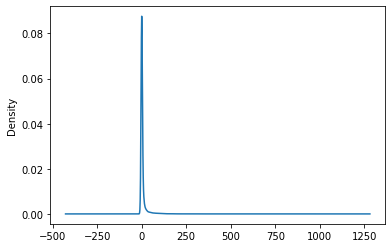

In [91]:
train.qtdIngressos.plot.density();

In [92]:
train.hora.value_counts()

21    7200
18    4539
15    4502
16    3435
19    3149
17    2048
14     481
20     373
23      14
22      10
0        6
13       1
Name: hora, dtype: int64

### Quantidade de sessões também significa quantidades de ingresso ?

- Hipotese Nula:<br>
Não existe uma relação entre quantidade de sessões e quantidade de ingressos


- Hipotese Alternativa:<br>
Existe uma relação uma relação entre quantidade de sessões e quantidade de ingressos

In [93]:
#@title Quantas sessões cada filme teve ?
#@markdown A principio **Rei leão** teve **858 sessões**, **190 sessões** a 
#@markdown mais que o segundo da lista, enquanto **Todo Dinheiro do mundo**
#@markdown teve **5 sessões**

train.nomeFilme.value_counts()

O Rei Leão                                   858
Frozen 2                                     668
Vingadores: Ultimato                         645
Hotel Transilvânia 3 - Férias Monstruosas    626
O Grinch                                     499
                                            ... 
Viva - A Vida É uma Festa                     14
Jogos Mortais: Jigsaw                         14
Luta por Justiça                              13
Pai em Dose Dupla 2                            7
Todo Dinheiro do Mundo                         5
Name: nomeFilme, Length: 162, dtype: int64

In [94]:
#@title Existe correlação entre sessões e vendas ?

#@markdown O grafico mostra uma certa correlação, porém existe alguns
#@markdown outliers, existe um filme que teve mais **600** sessões e vendeu
#@markdown a mesma quantidade que um filme com **300** sessões.

configure_plotly_browser_state()

filmes_agrupados_sessao_somados = (train.groupby('slug')
.agg({'nomeFilme':'count', 'qtdIngressos':'sum'})
.reset_index()
.rename(columns={'nomeFilme':'Quantidade Sessao'})
.sort_values("Quantidade Sessao", axis=0, ascending = True))

filmes_agrupados_sessao_somados['media'] = filmes_agrupados_sessao_somados['qtdIngressos'] / filmes_agrupados_sessao_somados['Quantidade Sessao']

trace_scatter = go.Scatter(x = filmes_agrupados_sessao_somados['Quantidade Sessao'],
                           y = filmes_agrupados_sessao_somados.qtdIngressos,
                           mode = 'markers')

data = [trace_scatter]

layout = go.Layout(title='Filmes agrupados, quantidade de vendas, quantidade de sessão',
                   yaxis={'title':'Quantidade de ingresso total'},
                   xaxis={'title':'Quantidade de sessão por filme'})

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [95]:
#@title O filme em questão é **Hotel Transilvania 3**

filmes_agrupados_sessao_somados.tail()

,slug,Quantidade Sessao,qtdIngressos,media
102,o-grinch,499,554.0,1.110220
71,hotel-transilvania-3-ferias-monstruosas,626,2113.0,3.375399
156,vingadores-ultimato,645,35531.0,55.086822
57,frozen-2,668,9004.0,13.479042
111,o-rei-leao,858,27902.0,32.519814


In [96]:
configure_plotly_browser_state()

trace_box = go.Box(y = filmes_agrupados_sessao_somados.qtdIngressos,
                   name = "Ingressos")

data = [trace_box]

layout = go.Layout(title="Detalhes da distribuição da quantidade de ingressos por filme",
                   yaxis = {'title': 'Quantidade de ingresso'})

fig = go.Figure(data, layout)

py.iplot(fig)

In [97]:
configure_plotly_browser_state()

trace_box = go.Box(y = filmes_agrupados_sessao_somados['Quantidade Sessao'],
                   name='Sessões')

layout = go.Layout(title="Detalhes da distribuição da quantidade de sessões por filme",
                   yaxis = {'title': 'Quantidade de sessões'})

fig = go.Figure(data, layout)

py.iplot(fig)

In [98]:
#@markdown ## Lembrando que isto não representa o que vende em cada sessão do filmme

configure_plotly_browser_state()

trace_box = go.Box(y = filmes_agrupados_sessao_somados['media'],
                   name='Media')

data = [trace_box]

layout = go.Layout(title="Detalhes da distribuição da media entre sessões e ingressos",
                   yaxis = {'title': 'Quantidade media'})

fig = go.Figure(data, layout)

py.iplot(fig)

In [102]:
agrupado_slug_data = train_featured.groupby(['slug','data'])['qtdIngressos'].sum().reset_index()

agrupando_por_data = agrupado_slug_data.groupby(['slug'])['data'].count().reset_index()

agrupando_por_data['semanas'] = agrupando_por_data['data'] / 7

agrupando_por_data.sort_values("data", axis=0, ascending = True)

agrupando_por_data_sem_semanas = agrupando_por_data.loc[agrupando_por_data['semanas'] > 1]

configure_plotly_browser_state()

trace_scatter = go.Bar(x = agrupando_por_data_sem_semanas['slug'],
                           y = agrupando_por_data_sem_semanas.semanas)

data = [trace_scatter]

layout = go.Layout(title='Quantidade de semanas para cada filme')

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [110]:
configure_plotly_browser_state()

trace_box = go.Box(y = agrupando_por_data_sem_semanas.semanas,
                   name = "Semanas")

data = [trace_box]

layout = go.Layout(title="Quantidade de semanas por filme",
                   yaxis = {'title': 'Quantidade de semana'})

fig = go.Figure(data, layout)

py.iplot(fig)


### Porém, o que isso significa?<br> 
Aumentar a sessão por que vende mais ?<br> Ou<br>
Esta vendendo bem por que existe mais sessão ?

As vendas nos primeiros dias faz gerar mais sessões? <br>

*Com o dataset atual tem como mediar a "empolgação"?*


### Um problema de negócio.

Sabe-se que a cada 7 dias é gerado uma nova grade de exibição.

Apartir do primeiro dia ao setimo, significa que este filme esteve mais de uma vez na grade de exibição. É preciso contar a quantidade de vezes que o filme ficou na grade, assim acompanhando as suas vendas a cada 'semana de exibição'

### Referência de negócio
De acordo com a tese de doutorado de André (2017), existe um limiar a ser seguido na primeira semana do filme, basicamente se a venda da primeira semana do filme for maior que a media, ele tem a possobilidade de repetir esse padrão novamente.

## Isto leva a crer que estamos querendo prever a primeira semana do filme

Depois por dia e depois por horario de sessão